# Tools & Agent (도구와 에이전트)

## Tools (도구)

도구(Tools) 는 에이전트가 특정 행동을 수행하기 위해 호출하는 구성 요소입니다.  
이들은 모델이 명확히 정의된 입력과 출력을 통해 외부 세계와 상호작용할 수 있도록 하여 모델의 기능을 확장합니다.

도구는 호출 가능한 함수(callable function) 와 그에 대한 입력 스키마(input schema) 를 캡슐화합니다.
이러한 도구들은 호환되는 채팅 모델(chat model) 에 전달될 수 있으며, 모델은 도구를 언제, 어떤 인수(argument) 로 호출할지 스스로 결정할 수 있습니다.

## Agent (에이전트)

에이전트(Agents)는 언어 모델과 도구를 결합하여 작업에 대해 추론하고, 사용할 도구를 결정하며, 솔루션을 향해 반복적으로 작업할 수 있는 시스템을 만듭니다. `create_agent`는 프로덕션에 바로 사용 가능한 에이전트 구현을 제공합니다. LLM 에이전트는 목표를 달성하기 위해 도구를 반복적으로 실행합니다.

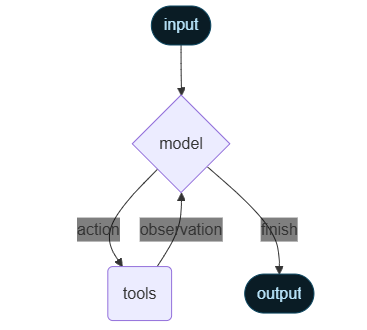

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

### LLM 연결


In [2]:
from langchain.chat_models import init_chat_model

# model = init_chat_model("gpt-5-nano", model_provider="openai")
model = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

## 도구 정의 

가장 간단하게 도구를 만드는 방법은 `@tool` 데코레이터를 사용하는 것입니다.  

**Type hints** 는 필수입니다. 이들은 도구의 **입력 스키마(input schema)** 를 정의하기 때문입니다.  
**독스트링(docstring)** 은 모델이 도구의 목적을 이해할 수 있도록 **간결하면서도 유용한 정보**를 포함해야 합니다.


In [4]:
from langchain.tools import tool

@tool
def search_db(query: str, limit: int = 10) -> str:
    """검색어(query)에 해당하는 고객 데이터베이스 레코드를 조회합니다.

    Args:
        query: 검색할 키워드 또는 문장
        limit: 반환할 최대 결과 개수
    """
    return f"'{query}'에 대한 검색 결과 {limit}개를 찾았습니다."

search_db

StructuredTool(name='search_db', description='검색어(query)에 해당하는 고객 데이터베이스 레코드를 조회합니다.\n\n    Args:\n        query: 검색할 키워드 또는 문장\n        limit: 반환할 최대 결과 개수', args_schema=<class 'langchain_core.utils.pydantic.search_db'>, func=<function search_db at 0x000002F5C6E823E0>)

### 도구 속성 사용자 정의

기본적으로 도구의 이름은 **함수 이름**에서 가져옵니다.  
더 설명적인 이름이 필요할 경우에는 이를 **재정의(override)** 할 수 있습니다.  
또한, 모델이 도구를 더 명확하게 이해하도록 하기 위해, 자동으로 생성된 도구 설명을 **재정의(override)** 할 수 있습니다.


In [5]:
@tool("calculator", description="산술 계산을 수행합니다. 수학 문제를 풀 때 이 도구를 사용하세요.")
def calc(expression: str) -> str:
    """수학 표현식을 계산합니다."""
    print("\n--- calculator 도구 실행됨 ---")
    return str(eval(expression))
calc

StructuredTool(name='calculator', description='산술 계산을 수행합니다. 수학 문제를 풀 때 이 도구를 사용하세요.', args_schema=<class 'langchain_core.utils.pydantic.calculator'>, func=<function calc at 0x000002F5C383BF60>)

### 고급 스키마 정의

Pydantic 모델이나 JSON 스키마를 사용하여 복잡한 입력을 정의합니다.

- Free Weather API 이용한 함수 도구 작성  
https://open-meteo.com/


In [6]:
from pydantic import BaseModel, Field
from langchain_core.tools import tool
import requests

# 입력 데이터 구조 정의 (Pydantic 사용)
class WeatherInput(BaseModel):
    """날씨 질의에 사용할 입력 스키마"""
    latitude: float = Field(description="질의할 지역의 위도를 입력합니다.")
    longitude: float = Field(description="질의할 지역의 경도를 입력합니다.")

# 현재의 온도 가져오기
@tool(args_schema=WeatherInput)
def get_weather(latitude, longitude):
    """
    제공된 좌표의 현재 기온을 섭씨(Celsius) 단위로 가져옵니다.
    """
    print('get_weather 도구 호출됨')
    response = requests.get(f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&current=temperature_2m")
    data = response.json()
    return data['current']['temperature_2m']

# 서울의 위도, 경도
get_weather.invoke({'latitude': 37.56667, 'longitude': 126.97806})

get_weather 도구 호출됨


4.2

### LangChain 내장 도구 사용

LangChain은 다양한 내장 도구를 제공합니다. 예를 들어, 웹 검색을 위한 `TavilySearch` 도구를 사용할 수 있습니다.

**참고**: `langchain_tavily` 패키지가 필요합니다.
```bash
pip install langchain_tavily
```

In [7]:
from langchain_tavily import TavilySearch

# 웹 검색을 도구
tavily = TavilySearch(max_results=2)

# 도구 테스트
print(tavily.invoke("LangGraph에서 '노드(node)'란 무엇인가요?"))

{'query': "LangGraph에서 '노드(node)'란 무엇인가요?", 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://s-core.co.kr/insight/view/langchain%EC%9D%98-%EC%83%88%EB%A1%9C%EC%9A%B4-%EB%9D%BC%EC%9D%B4%EB%B8%8C%EB%9F%AC%EB%A6%AC-langgraph-%ED%9B%91%EC%96%B4%EB%B3%B4%EA%B8%B0/', 'title': 'LangChain의 새로운 라이브러리 LangGraph 훑어보기 - 에스코어', 'content': 'LangGraph는 이름과 같이 작업을 그래프 형태로 모델링 하여 각 작업의 단계를 노드(Node)와 간선(Edge)으로 관리하고\xa0분기, 루프, 상태 관리 등을 통해 복잡한 작업 흐름을 체계적으로 처리할 수 있다. (두 째 인수는 선택적(설정 값)으로 추가될 수 있다) 노드는 사용자 정의에 따라 여러 가지 기능을 수행할 수 있다. (아래 예와 같이 START 노드를 이용해 첫 시작 노드를 간선으로 연결하거나,\xa0*set\\_entry \\_point*\xa0메소드를 통해 시작 노드를 지정할 수 있다) END 노드는 정의된 워크플로우가 종료됨을 의미한다. 이를 통해 정의된 그래프를 한 눈에 시각화 할 수 있다. 이 구조를 이용해 여러 에이전트가 협력하여 작업을 수행하거나, 조건에 따라 작업 흐름이 달라지거나 반복되어야 하는 복잡한 워크플로우를 구축하는데 유용한 도구가 될 수 있다.', 'score': 0.99992216, 'raw_content': None}, {'url': 'https://x2bee.tistory.com/430', 'title': '[LangGrpah] 2. LangGrpah(랭그래프)의 핵심 요소의 개념적 이해', 'content': '2. Node는 일종의 함수로 특정한 기능을 수행한 

도구의 속성을 확인해보겠습니다.


In [8]:
import json

# LLM에 입력 되는 값 확인
print("**** 도구 이름 ****")
print(tavily.name)
print()
print("**** 도구 설명 ****")
print(tavily.description)
print()
print("**** 도구 인자 ****")
print(json.dumps(tavily.args_schema.model_json_schema(), indent=2))

**** 도구 이름 ****
tavily_search

**** 도구 설명 ****
A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.

**** 도구 인자 ****
{
  "description": "Input for [TavilySearch]",
  "properties": {
    "query": {
      "description": "Search query to look up",
      "title": "Query",
      "type": "string"
    },
    "include_domains": {
      "anyOf": [
        {
          "items": {
            "type": "string"
          },
          "type": "array"
        },
        {
          "type": "null"
        }
      ],
      "default": [],
      "description": "A list of domains to restrict search results to.\n\n        Use this parameter when:\n        1. The user explicitly requests inf

## ReAct Agent 생성

이제 정의한 도구들을 사용하여 에이전트를 생성하겠습니다.


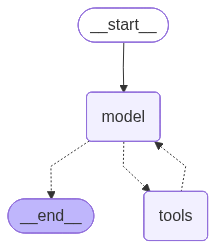

In [9]:
from langchain.agents import create_agent

# ReAct 에이전트 생성
agent = create_agent(
    model=model,
    tools=[tavily, search_db, calc, get_weather]  # Agent가 사용할 도구 목록
)

agent

## Agent 호출 (Invocation)

에이전트는 State(상태) 에 대한 업데이트를 전달하여 호출할 수 있습니다.  
모든 에이전트는 상태 안에 메시지들의 시퀀스(sequence of messages) 를 포함하고 있으며, 에이전트를 호출하려면 새로운 메시지를 전달하면 됩니다.


In [10]:
# 날씨 조회 예제
result = agent.invoke(
    {"messages": [
        {'role': 'system', "content": "당신은 도움이 되는 어시스턴트입니다. 주어진 도구를 이용해 답변하세요."},
        {"role": "user", "content": "지금 서울 기온이 몇도인가요?"}
    ]}
)

result['messages'][-1].pretty_print()

================================== Ai Message ==================================

[{'type': 'text', 'text': '서울의 위도와 경도를 알려주시면 현재 기온을 알려드릴 수 있습니다.', 'extras': {'signature': 'Ct0GAdHtim849Zl/QJclLb+bq0a6Uaix/iJ7xywe07ETyKVuDpz3WmcGeF4p9XMiH6u/9XSR0sGaGs+gvU5QU6bJsGXjXgw8fj3OtueiMkytV/UC33ZuP9H0cXAyYGDFb6lIZLdMHqHWLL1N6r8Kv6v4dKrtasjsrwHbaui0RLppi2FoD9lE3tAJW4Edvm6iydow173n6hscN4BKNSCgbUApC+C1D2aFCW/Xy+wie/cJbX6+bPIANP3FZCEqQ7kDPKX/EDk4SJh8uWwLBuwPyNFoPfX/l56qrlhMzqxd4BzESH4xZnVpYKQWukqsvPN8vamAzKnreWht9JzX6gK6R2PsgFNRYqOPkNyYFnynED7CiKge/cpZKAJEjsp7Cs2F43FHuSnZfp4w3YHVnFH/ef4+Dn4Yb1D9epdsRgmo0I5SZjLnSCTnga+nmwgWyPKRpnPXXngP/o+OcBOl1bz2aofr9yYMSfMxV9AQLu2iR0xAutp1eSYFtHfA8+eR27NtE+7Qis21P0hM0mYR65JbTIlTVUvMveFggu+DDItdzp3aY+EI5delTbtEuJxrhWqxgCfjqQ3y0mfUs+V9o4dHAaxis3fH1jp8/HLtnatTu6jghCAzT3uB6wtgJc7LhXSejmd9YxR3Uvnnrfbl9ifQ7jYKQ9y2sNRi+OqEjC2TT/j4bm1gwTnhWGRfAFKmiGCjbzwMa9TmJEnvfoJzjl++iIyYW1IO4JGUvyDgiWe9OOge3WSZEXLh68CxRyYuJg0KI1DzA1aVNOkmhScsdU/3Q/qCgtO6xXEugTYHGBlSO6OoquZp2lza5b504X

In [11]:
# 계산 예제
result_calc = agent.invoke(
    {"messages": [
        {"role": "user", "content": "3 + 7 * 2 를 계산해줘. 주어진 도구를 이용해서 계산해줘."}
    ]}
)
result_calc["messages"][-1].pretty_print()


--- calculator 도구 실행됨 ---
================================== Ai Message ==================================

3 + 7 * 2의 결과는 17입니다.


In [12]:
# 웹 검색 예제
result = agent.invoke(
    {"messages": [
        {'role': 'system', "content": "당신은 도움이 되는 어시스턴트입니다. 주어진 도구를 이용해 답변하세요."},
        {"role": "user", "content": "최근 한국의 big news 는 어떤 것이 있나요?"}
    ]}
)

result['messages'][-1].pretty_print()

================================== Ai Message ==================================

[{'type': 'text', 'text': '최근 한국의 주요 뉴스 두 가지는 다음과 같습니다.\n\n*   **남북한 국경 긴장 완화 제안**: 대한민국은 북한 군인들의 반복적인 국경 침범으로 인한 군사적 긴장을 완화하기 위해 북한에 회담을 제안했습니다.\n*   **국내 투자 확대**: 삼성전자와 기타 주요 한국 기업들이 미국과의 무역 협정 이후 국내 투자 계획을 발표했습니다.', 'extras': {'signature': 'Cu4GAdHtim+6ca9RiMTpccPLmnjCxFvDxT3PKGPINK2Uaj354ocyN8O4dX7ysncXHWFk9sHpnPO7RO35bjNTnyeWRD/F0vIYBAkfLCVx+s1mVWLU7fJ1+1ecYdQW0HEKPoX5y6y8cdd4moG2hT+pDyWvir7hiBA7mKlToxXGasgf2Ovu2qmkia0oVe5fKUCRa0GaQ0xVSZ5GLXvRIdQuQlVm47a1supMORNvcNDneY7LlaIKyLSGcvxzJCQDQ76W4bMSRDqNU/Pft62t0Fzt1ZbmzPeMzcrzadgxcIUhbAZp0YB6Qv4a/39dbXH0+pFFXF4LxCCOz3PX0OjB9UHDi2COBmvm5v52pM4k9ulespPcDXS/AyA/mi2O1ySSpfL3T0XnhZwJthzYgYtyLgksr7PXZH6ZIxJ7QZKH5BVBLDJ7EAzTd0MWyvs0AW6CIfetXVUXY/0rrC0EwJ3vTKwk52rkj5ujuyh5Mtyg+0tZUIF8iNoSqtYXaszlXR7q9ekrjbTQymSthhMcNRHATP48OKDJQJylm6a9y8l1LSWlbemIpA4xLOwA3gmpyQK6+Eo3KumRT18QSYDQt7bgpJBTtjm0aEgrOBhs5Opsl0RP6GmUECFgco1O3ZSg8Oj4GcQz3SHlyG7gzftr8pGTxdgsFyMYQc+OyPCSaE

## 동적 모델(Dynamic model)

동적 모델은 현재 **상태(state)** 와 **컨텍스트(context)** 를 기반으로 **런타임** 에 선택됩니다. 이를 통해 정교한 라우팅 로직과 비용 최적화가 가능합니다. 동적 모델을 사용하려면 `@wrap_model_call` 데코레이터를 사용하여 요청의 모델을 수정하는 미들웨어를 생성합니다.

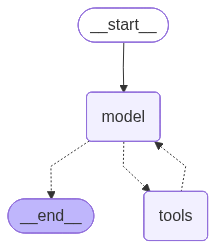

In [13]:
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

from langchain.agents import create_agent
from langchain.agents.middleware import wrap_model_call, ModelRequest, ModelResponse

# basic_model = ChatOpenAI(model="gpt-5-nano")
# advanced_model = ChatOpenAI(model="gpt-5-mini")

basic_model = ChatGoogleGenerativeAI(model="gemini-2.5-pro")
advanced_model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

@wrap_model_call
def dynamic_model_selection(request: ModelRequest, handler) -> ModelResponse:
    """대화의 복잡도에 따라 사용할 모델을 동적으로 선택"""

    # 현재 대화에서 주고받은 메시지 개수를 계산
    message_count = len(request.state["messages"])

    # 메시지가 10개를 초과하면 복잡한 대화로 간주 → 고급 모델 사용
    if message_count > 10:
        # 긴 대화일 경우 고급(Advanced) 모델 사용
        model = advanced_model
    else:
        # 짧은 대화일 경우 기본(Basic) 모델 사용
        model = basic_model

    # 선택된 모델을 request에 설정
    request.model = model

    # handler를 호출하여 요청 처리 계속 진행
    return handler(request)

agent_dynamic = create_agent(
    model=basic_model,  # Default model
    tools=[search_db, calc, get_weather],
    middleware=[dynamic_model_selection]
)

agent_dynamic

### 도구 오류 처리 (Tool error handling)

도구 실행 중 발생하는 오류를 커스터마이징하려면, `@wrap_tool_call` 데코레이터를 사용하여 미들웨어(middleware) 를 생성하면 됩니다.


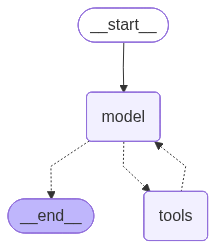

In [14]:
from langchain.agents import create_agent
from langchain.agents.middleware import wrap_tool_call
from langchain_core.messages import ToolMessage

@wrap_tool_call
def handle_tool_errors(request, handler):
    """도구 실행 중 발생하는 오류를 사용자 정의 메시지로 처리"""

    try:
        # 정상적으로 도구 요청을 처리
        return handler(request)

    except Exception as e:
        # 오류 발생 시 모델에게 사용자 친화적인 에러 메시지를 반환
        return ToolMessage(
            content=f"도구 오류: 입력값을 확인하고 다시 시도해주세요. (오류 내용: {str(e)})",
            tool_call_id=request.tool_call["id"]
        )

agent_error_handling = create_agent(
    model=model,
    tools=[search_db, get_weather],
    middleware=[handle_tool_errors]
)

agent_error_handling

### 시스템 프롬프트 (System prompt)

에이전트가 작업을 수행하는 방식을 제어하려면 시스템 프롬프트(System prompt) 를 제공할 수 있습니다.  
이때, `system_prompt` 매개변수는 문자열(String) 형태로 지정할 수 있습니다.


In [15]:
agent_with_prompt = create_agent(
    model=model,
    tools=[search_db, calc, get_weather],
    system_prompt="당신은 도움이 되는 어시스턴트입니다. 간결하고 정확하게 답변하세요."
)

result = agent_with_prompt.invoke(
    {"messages": [{"role": "user", "content": "LangChain 이란 무엇인지 한 문장으로 설명해줘."}]}
)

result['messages'][-1].pretty_print()

================================== Ai Message ==================================

LangChain은 대규모 언어 모델을 사용하는 애플리케이션 개발을 돕는 프레임워크입니다.


### 동적 시스템 프롬프트 (Dynamic system prompt)

실행 시점의 컨텍스트(runtime context) 나 에이전트 상태(agent state) 에 따라 시스템 프롬프트를 동적으로 변경해야 하는 고급 사용 사례에서는 미들웨어(middleware) 를 사용할 수 있습니다.  
`@dynamic_prompt` 데코레이터를 사용하면, 모델 요청(model request) 에 따라 시스템 프롬프트를 동적으로 생성하는 미들웨어를 만들 수 있습니다.  

`ModelRequest` 안에는 모델 호출에 필요한 모든 정보가 들어 있습니다. (예: 모델 이름, 입력 메시지들, 현재까지의 내부 상태, 도구 사용 여부, 런타임(runtime) 객체 등)

`request.runtime`은 LangChain v1의 Agents SDK / Middleware 시스템에서 “현재 실행 중인 에이전트 호출의 런타임 상태(runtime state)” 를 담고 있는 객체입니다.

즉, agent.invoke()가 실행되는 순간의 컨텍스트(context), 도구 호출 정보, 메시지 히스토리 등을 담고 있으며, 미들웨어(dynamic_prompt 등)가 이를 읽어서 동적으로 프롬프트나 행동을 바꾸는 데 사용합니다.

In [16]:
from typing import TypedDict

from langchain.agents import create_agent
from langchain.agents.middleware import dynamic_prompt, ModelRequest

class Context(TypedDict):
    user_role: str

@dynamic_prompt
def user_role_prompt(request: ModelRequest) -> str:
    """사용자 역할(user role)에 따라 시스템 프롬프트를 생성"""

    # 실행 컨텍스트(runtime context)에서 사용자 역할 정보를 가져옴
    # 기본값은 "user"
    user_role = request.runtime.context.get("user_role", "user")

    # 기본 프롬프트 정의
    base_prompt = "당신은 도움이 되는 어시스턴트입니다."

    # 사용자 역할에 따라 프롬프트를 다르게 설정
    if user_role == "expert":
        # 전문가(expert)인 경우: 기술적으로 자세한 답변을 제공
        return f"{base_prompt} 기술적으로 자세하고 전문적인 답변을 제공하세요."
    elif user_role == "beginner":
        # 초보자(beginner)인 경우: 쉬운 설명과 비전문 용어 사용
        return f"{base_prompt} 개념을 쉽게 설명하고 전문 용어 사용을 피하세요."

    return base_prompt

agent_dynamic_prompt = create_agent(
    model=model,
    tools=[search_db, calc, get_weather],
    middleware=[user_role_prompt],
    context_schema=Context
)

# 실행 컨텍스트(context)에 따라 시스템 프롬프트가 동적으로 설정됨
result = agent_dynamic_prompt.invoke(
    {
        "messages": [
            {"role": "user", "content": "기계 학습(machine learning)을 한 문장으로 설명해줘."}
        ]
    },
    context={"user_role": "expert"}  # 사용자 역할을 '전문가'로 지정
)

result['messages'][-1].pretty_print()

================================== Ai Message ==================================

기계 학습은 컴퓨터가 명시적으로 프로그래밍되지 않고도 데이터로부터 학습하고 예측하거나 결정을 내릴 수 있도록 하는 인공지능의 한 분야입니다.


### 구조화된 출력 (Structured output)

특정 상황에서는 에이전트가 정해진 형식의 출력 결과를 반환하도록 하고 싶을 때가 있습니다.  
이때 LangChain은 `response_format` 매개변수를 통해 구조화된 출력을 생성하는 여러 가지 방법을 제공합니다.


In [17]:
from pydantic import BaseModel
from langchain.agents import create_agent
from langchain.agents.structured_output import ToolStrategy

class ContactInfo(BaseModel):
    name: str
    email: str
    phone: str

agent_structured = create_agent(
    model=model,
    tools=[search_db, calc, get_weather],
    response_format=ToolStrategy(ContactInfo)
)

result = agent_structured.invoke({
    "messages": [{"role": "user", "content": "다음에서 연락처 정보를 추출하세요: John Doe, john@example.com, (555) 123-4567"}]
})

result["structured_response"]

ContactInfo(name='John Doe', email='john@example.com', phone='(555) 123-4567')